# Image Processing

In this notebook, we examine all raw cropped cell images and prepare them for classification by filtering and augmentation.

## 1. Image Examination

It is a good practice to visualize all images together first. It helps us to get a big idea of what image processing methods are needed for the dataset.

We can use [ImageMagic Montage](https://www.imagemagick.org) to easily display all images.

In [1]:
!montage ./images/sample_images/original/*/*/*.png ./plots/before_padding.png

![](./plots/before_padding.png)

## 2. Image Resizing

We notice the size variation from all images. It is more convenient to work with images with equal shapes. Therefore, we want to assess the relationship between image size and cell activity classification, then choose image resizing methods accordingly.

### 2.1. Image Size Distribution

In [62]:
import re
import os
import cv2
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.patches as mpatches
from glob import glob
from os.path import join, exists, basename, normpath, split
from matplotlib import pyplot as plt
from PIL import Image
from shutil import copyfile

In [3]:
def sum_hist(input_dir):
    """
    Find the histogram over all grayscale images in the input_dir.
    Instead of listing all images into one matrix, simply sum the intensity.
    
    Args:
        input_dir (string): path of the directory containing all png images
    
    Returns:
        array: A length 256 array corresponding to the pixel intensity frequency
    """
    hist = np.zeros(256)
    count = 0
    for image in glob(join(input_dir, "*.png")):
        # Read the image
        img = cv2.imread(image, 0)
        cur_hist = cv2.calcHist([img],[0], None, [256], [0,256]).flatten()
        hist = hist + cur_hist
        count += 1
     
    # Compute the frequency
    return hist / sum(hist)

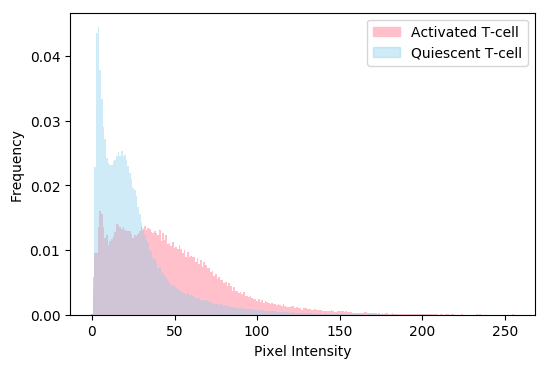

In [4]:
# Plot the pixel intensity frequency 
act_hist = sum_hist("./images/sample_images/original/*/activated")
qui_hist = sum_hist("./images/sample_images/original/*/quiescent")

plt.figure(dpi=100)
plt.bar(range(256), act_hist, width=1, align='center', color="pink")
plt.bar(range(256), qui_hist, width=1, align='center', color=(135/255, 206/255, 235/255, 0.4))
pink_patch = mpatches.Patch(color='pink', label='Activated T-cell')
blue_patch = mpatches.Patch(color=(135/255, 206/255, 235/255, 0.4), label='Quiescent T-cell')
plt.legend(handles=[pink_patch, blue_patch])
plt.ylabel('Frequency')
plt.xlabel('Pixel Intensity')
plt.show(2)

### 2.2. Image Padding

Based on the distribution above, quiescent cell images are more likely to have lower intensities (dimmer). Therefore, we want to preserve the original image size after unifying all image shapes. One way to achieve this is to add paddings to all images. We first find the largest width $w$ and height $h$, then make all images have the same square shape ($\max\left(w, h\right) \times \max\left(w, h\right)$) by adding black borders around them.

It is not necessarily to resize all images to the largest size. For example, if there are some extremely large images (outliers) in your dataset, you might want to discard them before choosing the $\max\left(w, h\right)$.

In [5]:
def get_max_dimension(input_dir, top_num=3):
    """
    Find `top_num` largest dimension (height or width) of all images in the input_dir.
    You can visualize the image source to decide which diemsion value to use.
    
    Args:
        input_dir (string): A directory containing png images
        top_num (integer): Number of largest lengths to return
    
    Returns:
        list(tuple): A list of top `top_num` dimension lengths and their associated
            image names
    """
    lengths = []
    for image in glob(join(input_dir, "*.png")):
        img = Image.open(image)
        width, height = img.size
        lengths.append((max([width, height]), image, width, height))

    # Get the top 3 options
    sorted_lengths = sorted(lengths, key=lambda x: x[0], reverse=True)
    return sorted_lengths[:top_num]

In [32]:
def add_padding(image, max_length, padding_color="black", output=None):
    """
    This function adds padding around the image so the new shape
    is (max_length * max_length).
    
    Args:
        image (string): path of the image file
        max_length (int): output square length
        padding_color (string): color of the borders
        output (string): output path of the result image. If it is
            None, then the new image is not saved
    
    Returns:
        array: the new image
    """

    img = Image.open(image)
    width, height = img.size

    # Create a new 8-bit B&W image with black background
    new_image = Image.new('L', (max_length, max_length), color=padding_color)

    # Put the original image in the center
    x_shift = (max_length - width) // 2
    y_shift = (max_length - height) // 2
    new_image.paste(img, (x_shift, y_shift,
                          width + x_shift, height + y_shift))
    
    # Save the image if needed
    if output:
        new_image.save(output)
    
    return np.array(new_image)

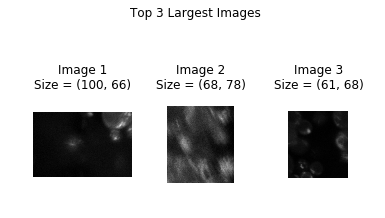

In [45]:
# Display the three largest images
largest_three = get_max_dimension("./images/sample_images/original/*/*")

# Add padding to these three images, so their displays have the same scale
padded_top_three = [
    add_padding(img[1], largest_three[0][0], padding_color="white") for img in largest_three
]

fig=plt.figure()

for i in range(3):
    img = padded_top_three[i]
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title("Image {}\nSize = ({}, {})".format(
        i+1, largest_three[i][2], largest_three[i][3]))

fig.suptitle("Top 3 Largest Images")
plt.show()

There is a significant gap between the largest length $100$ and the second largest length $78$, and Image 1 looks like an outlier due to bad cropping. Even though image 2 and image 3 are likely to suffer from bad cropping, we will discard Image 1 and use $78$ as the largest length to resize other images.

In [73]:
# Add padding to all images except Image 1 above
image_1 = largest_three[0][1]
max_length = 78

for image_path in glob("./images/sample_images/original/*/*/*.png"):
    # Ignore image 1
    if image_path == image_1:
        continue

    # Get the output path
    image_output = image_path.replace("original", "processed/padded")
    
    # Create intermediate directories if they do not exist yet
    intermediate_dirs, _ = os.path.split(image_output)
    if not exists(intermediate_dirs):
        os.makedirs(intermediate_dirs)
    
    # Process the current image
    add_padding(image_path, max_length, padding_color="black", output=image_output)

Then, we can visualize all padded images.

In [75]:
!montage ./images/sample_images/processed/padded/*/*/*.png -geometry +1+1 ./plots/after_padding.png

![](./plots/after_padding.png)

## 3. Image Filtering

As we have seen above, many images are very dim and there is no cell in the image. We want to design a filter to automatically detect those images.

### 3.1. Entropy Distribution